## AREBO Link Length Optimization
Notebook to carry out AREBO's link length optimization through a brute force parameter search.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import itertools
import functools
import pandas as pd
import progressbar as pb

In [4]:
import sys
import json
import os

sys.path.append("scripts")

In [5]:
from ipywidgets import widgets
from ipywidgets import interactive
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import areboopt as aropt

---

In [7]:
# Output data foler
outdir = "opt_data"

# Defining robot parameter ranges
d2r = np.pi / 180.
r2d = 180. / np.pi
robot_param = {'links': {'r1': [20., 30.], 'r2': [10., 20.],
                         'r3': [10., 15.], 'dr': 1.},
               'angles': {'t1': [d2r * -180., d2r * 180.],
                          't2': [d2r * -60., d2r * 180.],
                          't3': [d2r * -180., d2r * 180.],
                          't4': [d2r * -180., d2r * 180.],
                          't5': [d2r * -180., d2r * 180.],
                          't6': [d2r * -180., d2r * 180.]}
               }

# Save parameters
with open(f"{outdir}/robot_param_settings.json", "w") as f:
    json.dump(robot_param, fp=f)

In [8]:
# Defining human parameter ranges
hlimb_param = {'links': {'uh': [15., 20.], 'dr': 2.5},
               'angles': {'t1': [d2r * - 120, d2r * 0],
                          't2': [d2r * -50, d2r * 50],
                          'dt': 10 * np.pi / 180},
               'loc': {'x': [-10., 0, 10.],
                       'y': [-10., 0, 10.],
                       'z': [10., 20., 30.]}
               }

# Save parameters
# Save parameters
with open(f"{outdir}/hlimb_param_settings.json", "w") as f:
    json.dump(hlimb_param, fp=f)

In [9]:
# Optimization summary array.
goodarray = pd.DataFrame(columns=("r1", "r2", "r3", "shx", "shy", "shz",
                                  "uh", "g1", "g2", "g", "dataf"))

In [10]:
# All robot and human limb parametes.
all_hparam = np.array(aropt.iterate_over_hlimb_param(hlimb_param))
all_rparam = np.array(aropt.iterate_over_robotparam(robot_param))

# Save all robot and human parameters.
with open(f"{outdir}/all_hlimb_param.npy", 'wb') as f:
    np.save(f, all_hparam)
with open(f"{outdir}/all_robot_param.npy", 'wb') as f:
    np.save(f, all_rparam)

In [11]:
# Go through all human limb angles.
all_hangles, pha1, pha2 = aropt.all_hlimb_angles(hlimb_param)
Nha1, Nha2 = len(pha1), len(pha2)

# Go  through each robot parameter combination
Nr = len(all_rparam)
Nh = len(all_hparam)

# Progress bar
# define progress bar
widgets = ['[', pb.Timer(), '] ', pb.Bar(), ' (', pb.ETA(), ')']
bar = pb.ProgressBar(widgets=widgets, maxval=Nr * Nh).start()

for ir, _rparam in enumerate(all_rparam):
    for ih, _hparam in enumerate(all_hparam):
        # Shoulder position and upper-arm length.
        _shpos, _uh = _hparam[:3], _hparam[3]

        # Base file name.
        basename = "_".join(("r3s3l1",
                            f"{int(_rparam[0])}", f"{int(_rparam[1])}",
                            f"{int(_rparam[2])}", f"{int(_shpos[0])}",
                            f"{int(_shpos[0])}", f"{int(_shpos[0])}",
                            f"{int(_uh)}"))

        # Get the inverse kinematic map
        invkin_maps = aropt.get_invkinmaps(_rparam, _uh, _shpos, all_hangles,
                                           Nha1, Nha2, robot_param)
        
        # Compute "goodness" function
        gvals = aropt.get_goodness_score(invkin_maps)

        # Upate goodness array
        dfname = f"{outdir}/invkinmap_{basename}.npy"
        goodarray = goodarray.append({"r1": _rparam[0],
                                    "r2": _rparam[1],
                                    "r3": _rparam[2],
                                    "shx": _shpos[0],
                                    "shy": _shpos[1],
                                    "shz": _shpos[2],
                                    "uh": _uh,
                                    "g1": gvals[0],
                                    "g2": gvals[1],
                                    "dataf": dfname},
                                    ignore_index=True)

        # Save invkinmaps data and images
        with open(dfname, 'wb') as f:
            np.save(f, np.array([invkin_maps['reachable'],
                                 invkin_maps['fratio'],
                                 invkin_maps['rangles'][:, :, 0],
                                 invkin_maps['rangles'][:, :, 1],
                                 invkin_maps['rangles'][:, :, 2],
                                 invkin_maps['rangles'][:, :, 3],
                                 invkin_maps['rangles'][:, :, 4],
                                 invkin_maps['rangles'][:, :, 5]]))
        # Update progress.
        bar.update(ir * Nh + ih)
    # Save goodarray
    goodarray.to_csv(f"{outdir}/goodarray.csv", sep=",", index=False)

scripts\arebo.py:84: RuntimeWarning: invalid value encountered in arccos:--:--)
  ta3 = np.arccos(_n / _d)
scripts\arebo.py:90: RuntimeWarning: invalid value encountered in arccos
  beta = np.arccos(_n / _d)
scripts\areboopt.py:151: RuntimeWarning: invalid value encountered in double_scalars
  return np.array([(a + np.pi) % (2 * np.pi) - np.pi for a in angles])
scripts\areboopt.py:268: RuntimeWarning: invalid value encountered in less
  _fr[_fr < 1] = 0
scripts\areboopt.py:269: RuntimeWarning: invalid value encountered in greater_equal
  _fr[_fr >= 1] = 1


## Analyze goodness data

In [12]:
outdir = "opt_data"

In [13]:
# Read good array.
goodness = pd.read_csv(f"{outdir}/goodarray.csv")

# Read AREBO and human limb parameters
with open(f"{outdir}/robot_param_settings.json", "r") as f:
    robot_param = json.load(fp=f)
with open(f"{outdir}/hlimb_param_settings.json", "r") as f:
    hlimb_param = json.load(fp=f)

allgood = pd.DataFrame(columns=("r1", "r2", "r3", "O1", "O2", "O12sum", "O12prod"))

In [14]:
# Computer objective functions for each robot link combination.
all_rparam = np.array(aropt.iterate_over_robotparam(robot_param))

for _rparam in all_rparam:
    # Find all data corresponding to the given robot link
    # parameters.
    _rinx = ((goodness['r1'] == _rparam[0]) &
             (goodness['r2'] == _rparam[1]) &
             (goodness['r3'] == _rparam[2]))
    _O1 = np.mean(goodness[_rinx]['g1'])
    _O2 = np.mean(goodness[_rinx]['g2'])
    allgood = allgood.append({"r1": _rparam[0],
                              "r2": _rparam[1],
                              "r3": _rparam[2],
                              "O1": _O1,
                              "O2": _O2,
                              "O12sum": 0.5 * _O1 + 0.5 * _O2,
                              "O12prod": _O1 * _O2},
                              ignore_index=True)

# Save all good data.
allgood.to_csv(f"{outdir}/allgood.csv", sep=",", index=False)

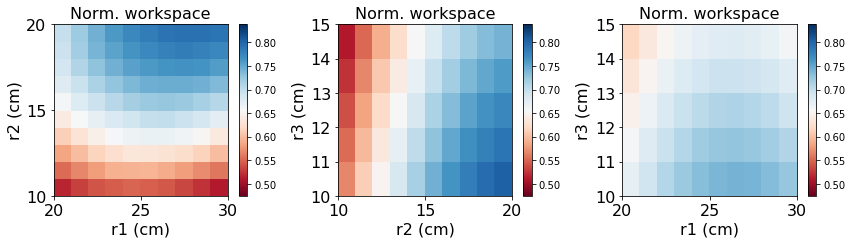

In [15]:
fig = aropt.plot_objective_heatmap(allgood, robot_param, objective="O1", title="Norm. workspace");
fig.savefig(f"{outdir}/img/object1.svg", format="svg", dpi=300);
fig.savefig(f"{outdir}/img/object1.png", format="png", dpi=300);

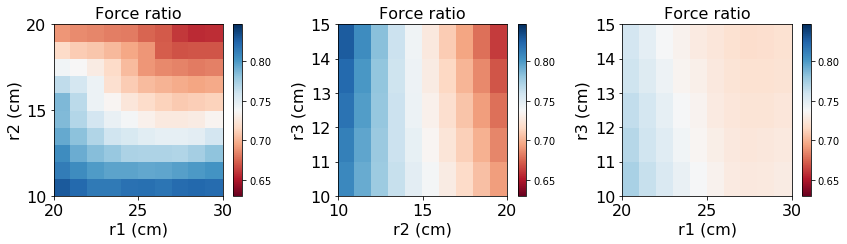

In [16]:
fig = aropt.plot_objective_heatmap(allgood, robot_param, objective="O2", title="Force ratio");
fig.savefig(f"{outdir}/img/object2.svg", format="svg", dpi=300);
fig.savefig(f"{outdir}/img/object2.png", format="png", dpi=300);

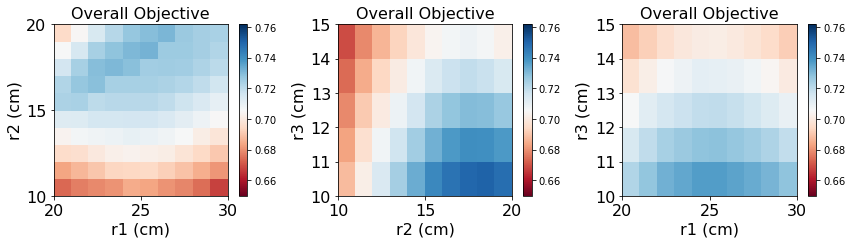

In [17]:
fig = aropt.plot_objective_heatmap(allgood, robot_param, objective="O12sum", title="Overall Objective");
fig.savefig(f"{outdir}/img/object12sum.svg", format="svg", dpi=300);
fig.savefig(f"{outdir}/img/object12sum.png", format="png", dpi=300);

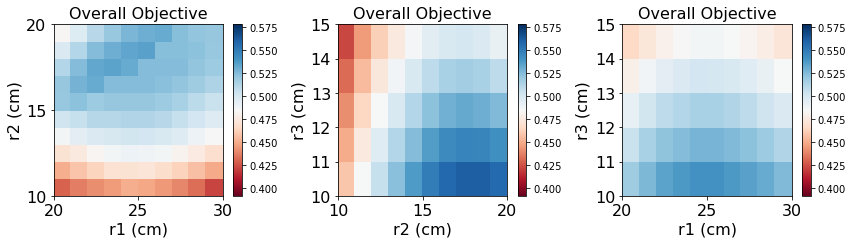

In [18]:
aropt.plot_objective_heatmap(allgood, robot_param, objective="O12prod", title="Overall Objective");

In [19]:
# Arrange the performance objective values in a descending order and 
# find the link lengths at the top.
_cols = ['r1', 'r2', 'r3', 'O1', 'O2', 'O12sum']
_allgoodsum = allgood[_cols].sort_values(by="O12sum", ascending=False)

# First 10 % of the values.
_objrange = _allgoodsum['O12sum'].max() - _allgoodsum[ 'O12sum'].min()
prcnt = 10
th = _allgoodsum['O12sum'].max() - (prcnt / 100.) * _objrange
_inx = _allgoodsum['O12sum'] >= th
print(len(_allgoodsum[_inx]))
print(_allgoodsum[_inx])

29
       r1    r2    r3        O1        O2    O12sum
522  27.0  20.0  10.0  0.837693  0.685731  0.761712
378  25.0  18.0  10.0  0.810843  0.712335  0.761589
450  26.0  19.0  10.0  0.825865  0.695793  0.760829
384  25.0  19.0  10.0  0.818959  0.696808  0.757883
312  24.0  18.0  10.0  0.798152  0.716734  0.757443
456  26.0  20.0  10.0  0.830009  0.684868  0.757439
588  28.0  20.0  10.0  0.838384  0.676313  0.757349
390  25.0  20.0  10.0  0.825002  0.687223  0.756113
306  24.0  17.0  10.0  0.787706  0.723879  0.755793
240  23.0  17.0  10.0  0.779332  0.731585  0.755459
318  24.0  19.0  10.0  0.809548  0.700024  0.754786
648  29.0  19.0  10.0  0.832599  0.675626  0.754113
720  30.0  20.0  10.0  0.837693  0.669381  0.753537
174  22.0  17.0  10.0  0.762669  0.744392  0.753531
576  28.0  18.0  10.0  0.820772  0.686259  0.753515
504  27.0  17.0  10.0  0.807217  0.699583  0.753400
516  27.0  19.0  10.0  0.828801  0.677674  0.753237
246  23.0  18.0  10.0  0.787533  0.718927  0.753230
714  30.0

In [20]:
print(_allgoodsum[_inx][['r1', 'r2', 'r3']].describe())

             r1         r2    r3
count  29.00000  29.000000  29.0
mean   26.37931  18.275862  10.0
std     2.36664   1.278854   0.0
min    22.00000  16.000000  10.0
25%    25.00000  17.000000  10.0
50%    27.00000  18.000000  10.0
75%    28.00000  19.000000  10.0
max    30.00000  20.000000  10.0


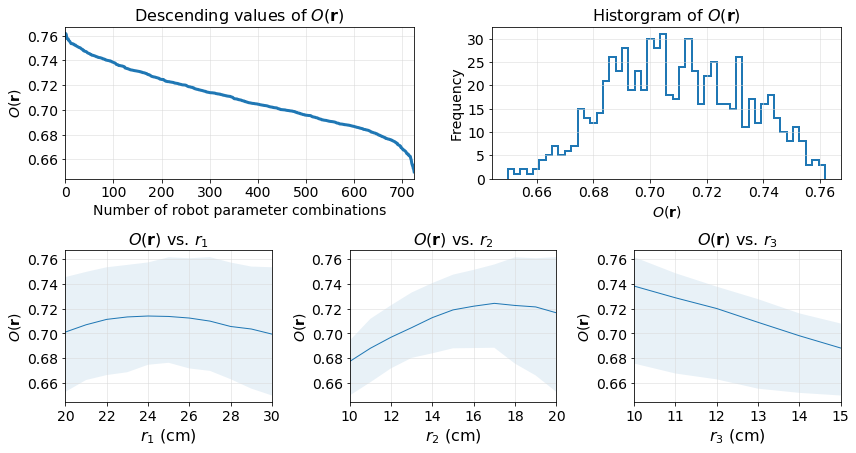

In [21]:
fig = figure(figsize=(12, 6.4))

# Different values of the objective function
ax = plt.subplot2grid((2, 6), loc=(0, 0), colspan=3)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.set_xlim(0, len(allgood) - 1)
ax.plot(_allgoodsum['O12sum'].to_list(), lw=3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel("Number of robot parameter combinations", fontsize=14)
ax.set_ylabel(r"$O\left(\mathbf{r}\right)$", fontsize=14)
ax.set_title(r"Descending values of $O\left(\mathbf{r}\right)$", fontsize=16)

# Historgram of objective function
ax = plt.subplot2grid((2, 6), loc=(0, 3), colspan=3)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
# ax.set_xlim(0, len(allgood) - 1)
ax.hist(allgood['O12sum'], lw=2, bins=50, histtype="step")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel(r"$O\left(\mathbf{r}\right)$", fontsize=14)
ax.set_ylabel(r"Frequency", fontsize=14)
ax.set_title(r"Historgram of $O\left(\mathbf{r}\right)$", fontsize=16)

# Objective function versus r1
ax = plt.subplot2grid((2, 6), loc=(1, 0), colspan=2)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
xvals, yvals = aropt.get_val_ranges(allgood, 'r1', 'O12sum')
ax.plot(xvals, yvals[:, 1], lw=1)
plt.fill_between(xvals, y1=yvals[:, 0], y2=yvals[:, 2], alpha=0.1)
ax.set_xlim(xvals[0],xvals[-1] )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel(r"$r_1$ (cm)", fontsize=16)
ax.set_ylabel(r"$O\left(\mathbf{r}\right)$", fontsize=14)
ax.set_title(r"$O\left(\mathbf{r}\right)$ vs. $r_1$", fontsize=16)

# Objective function versus r2
ax = plt.subplot2grid((2, 6), loc=(1, 2), colspan=2)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
xvals, yvals = aropt.get_val_ranges(allgood, 'r2', 'O12sum')
ax.plot(xvals, yvals[:, 1], lw=1)
plt.fill_between(xvals, y1=yvals[:, 0], y2=yvals[:, 2], alpha=0.1)
ax.set_xlim(xvals[0],xvals[-1] )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel(r"$r_2$ (cm)", fontsize=16)
ax.set_ylabel(r"$O\left(\mathbf{r}\right)$", fontsize=14)
ax.set_title(r"$O\left(\mathbf{r}\right)$ vs. $r_2$", fontsize=16)

# Objective function versus r3
ax = plt.subplot2grid((2, 6), loc=(1, 4), colspan=2)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
xvals, yvals = aropt.get_val_ranges(allgood, 'r3', 'O12sum')
ax.plot(xvals, yvals[:, 1], lw=1)
plt.fill_between(xvals, y1=yvals[:, 0], y2=yvals[:, 2], alpha=0.1)
ax.set_xlim(xvals[0],xvals[-1] )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel(r"$r_3$ (cm)", fontsize=16)
ax.set_ylabel(r"$O\left(\mathbf{r}\right)$", fontsize=14)
ax.set_title(r"$O\left(\mathbf{r}\right)$ vs. $r_3$", fontsize=16)

plt.tight_layout()

fig.savefig(f"{outdir}/img/objectsummary.svg", format="svg", dpi=300);
fig.savefig(f"{outdir}/img/objectsummary.png", format="png", dpi=300);

In [22]:
def group_data(df, grpcol, valcol, selinx):
    grpcolvals = df[grpcol].unique()
    valcolvals = [list(df[(df[grpcol] == _grpval) & selinx][valcol])
                  for _grpval in grpcolvals]
    return grpcolvals, valcolvals

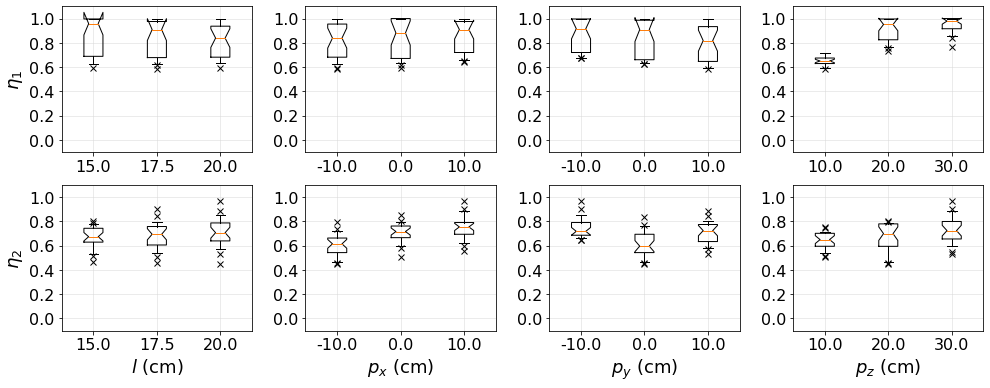

In [23]:
r1opt, r2opt, r3opt = 27, 20, 10

# Optimal link length selection index
_inxopt = ((goodness['r1'] == r1opt) &
           (goodness['r2'] == r2opt) &
           (goodness['r3'] == r3opt))

fig= figure(figsize=(14, 5.5))

# Plot the range of workspacce and force ratio values for different arm
# positions and lengths.
# Function of arm length.
uh, _g1 = group_data(goodness, grpcol='uh', valcol='g1', selinx=_inxopt)
_, _g2 = group_data(goodness, grpcol='uh', valcol='g2', selinx=_inxopt)

ax = fig.add_subplot(241)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.boxplot(_g1, notch=True, sym="kx", whis=[5, 95],
           positions=np.arange(1, len(uh) + 1));
ax.set_ylim(-0.1, 1.1);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(uh)
ax.set_ylabel(r"$\eta_1$", fontsize=18)
# ax.set_title(r"Normalized Workspace", fontsize=16)

ax = fig.add_subplot(245)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.boxplot(_g2, notch=True, sym="kx", whis=[5, 95],
           positions=np.arange(1, len(uh) + 1));
ax.set_ylim(-0.1, 1.1);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(uh)
ax.set_xlabel(r"$l$ (cm)", fontsize=18)
ax.set_ylabel(r"$\eta_2$", fontsize=18)
# ax.set_title(r"Normalized Force Ratio", fontsize=16)

# Function of shoulder x pos.
shx, _g1 = group_data(goodness, grpcol='shx', valcol='g1', selinx=_inxopt)
_, _g2 = group_data(goodness, grpcol='shx', valcol='g2', selinx=_inxopt)

ax = fig.add_subplot(242)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.boxplot(_g1, notch=True, sym="kx", whis=[5, 95],
           positions=np.arange(1, len(shx) + 1));
ax.set_ylim(-0.1, 1.1);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(shx)
# ax.set_title(r"Normalized Workspace", fontsize=16)

ax = fig.add_subplot(246)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.boxplot(_g2, notch=True, sym="kx", whis=[5, 95],
           positions=np.arange(1, len(shx) + 1));
ax.set_ylim(-0.1, 1.1);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(shx)
ax.set_xlabel(r"$p_x$ (cm)", fontsize=18)
# ax.set_title(r"Normalized Force Ratio", fontsize=16)

# Function of shoulder y pos.
shy, _g1 = group_data(goodness, grpcol='shy', valcol='g1', selinx=_inxopt)
_, _g2 = group_data(goodness, grpcol='shy', valcol='g2', selinx=_inxopt)

ax = fig.add_subplot(243)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.boxplot(_g1, notch=True, sym="kx", whis=[5, 95],
           positions=np.arange(1, len(shy) + 1));
ax.set_ylim(-0.1, 1.1);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(shy)
# ax.set_title(r"Normalized Workspace", fontsize=16)

ax = fig.add_subplot(247)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.boxplot(_g2, notch=True, sym="kx", whis=[5, 95],
           positions=np.arange(1, len(shy) + 1));
ax.set_ylim(-0.1, 1.1);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(shy)
ax.set_xlabel(r"$p_y$ (cm)", fontsize=18)
# ax.set_title(r"Normalized Force Ratio", fontsize=16)

# Function of shoulder z pos.
shz, _g1 = group_data(goodness, grpcol='shz', valcol='g1', selinx=_inxopt)
_, _g2 = group_data(goodness, grpcol='shz', valcol='g2', selinx=_inxopt)

ax = fig.add_subplot(244)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.boxplot(_g1, notch=True, sym="kx", whis=[5, 95],
           positions=np.arange(1, len(shz) + 1));
ax.set_ylim(-0.1, 1.1);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(shz)
# ax.set_title(r"Normalized Workspace", fontsize=16)

ax = fig.add_subplot(248)
ax.grid(color='0.85', linestyle='-', linewidth=0.5)
ax.boxplot(_g2, notch=True, sym="kx", whis=[5, 95],
           positions=np.arange(1, len(shz) + 1));
ax.set_ylim(-0.1, 1.1);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.set_xticklabels(shz)
ax.set_xlabel(r"$p_z$ (cm)", fontsize=18)
# ax.set_title(r"Normalized Force Ratio", fontsize=16)

plt.tight_layout()

fig.savefig(f"{outdir}/img/optobject.svg", format="svg", dpi=300);
fig.savefig(f"{outdir}/img/optobject.png", format="png", dpi=300);